# PART B: Student Segmentation

---

# Background Information

### Clustering helps us identify distinct groups of students based on similarities in their characteristics or performance patterns. By grouping students into clusters, we can tailor interventions and support strategies more effectively, addressing the specific needs of each group. This allows educators to make data-driven decisions to improve educational outcomes for all students.

---

### Importing Libraries

In [394]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# my seabron color palette
sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import gower
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from itertools import combinations
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift, SpectralClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
import time
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.cluster import hierarchy
import pickle

### Remove Future Warnings

In [395]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

# Data Exploration and Preprocessing


## Handling Missing Values

### First, I will clean the data by addressing missing values

In [396]:
# Load in my dataset
df_students = pd.read_csv('Data Files/Student_Performance_dataset.csv')

In [397]:
# check out my dataset
df_students.head()


,Student_ID,Gender,Age,English_Score,Math_Score,Science_Score
0,1,Female,18,64.0,56.0,60
1,2,Female,12,89.0,71.0,97
2,3,Female,18,69.0,69.0,80
3,4,Female,17,60.0,72.0,97
4,5,Male,13,71.0,76.0,76


In [398]:
print("\nInformation of dataset")
df_students.info()




Information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Student_ID     1000 non-null   int64  
 1   Gender         1000 non-null   object 
 2   Age            1000 non-null   int64  
 3   English_Score  971 non-null    float64
 4   Math_Score     967 non-null    float64
 5   Science_Score  1000 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 47.0+ KB


### Based on my observations, it seems that gender is a categorical object variable that may require encoding.

### Now im going to check for null values

In [399]:
df_students.isna().sum()

Student_ID        0
Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64

### It appears that the English scores column is missing 29 values, while the math score column is missing 33 values. To address this, I plan to explore the distribution of the dataset by plotting a density histogram. Subsequently, I will decide whether to impute the missing values with the mean or median of the respective columns.

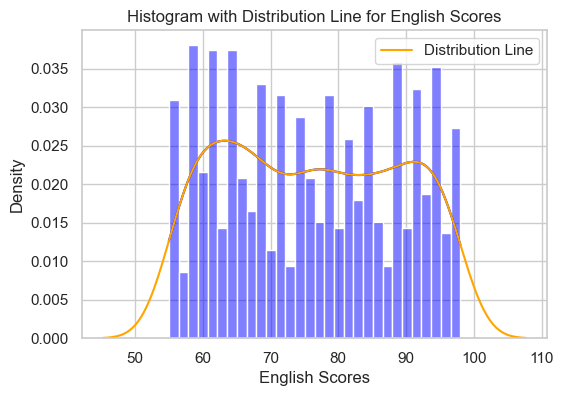

In [400]:
# first im going to check the english scores
english_scores = df_students['English_Score']

# plot the histogram 
plt.figure(figsize=(6, 4))
sns.histplot(english_scores, bins=30, kde=True, color='blue', stat='density')

# add distribution line
sns.kdeplot(english_scores, color='orange', linestyle='-', label='Distribution Line')

plt.title('Histogram with Distribution Line for English Scores')
plt.xlabel('English Scores')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


### Observing a relatively symmetric distribution line in the plot, indicative of a normal distribution, I plan to utilise the mean for imputing the missing values in the English scores column. Next let us check the plot for Math Scores.

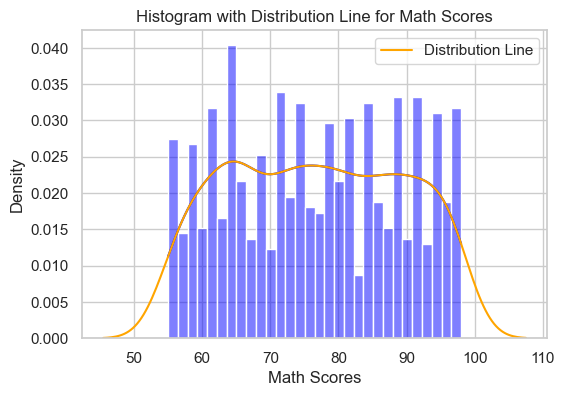

In [401]:
# first im going to check the math scores
math_scores = df_students['Math_Score']

# plot the histogram 
plt.figure(figsize=(6, 4))
sns.histplot(math_scores, bins=30, kde=True, color='blue', stat='density')

# add distribution line
sns.kdeplot(math_scores, color='orange', linestyle='-', label='Distribution Line')

plt.title('Histogram with Distribution Line for Math Scores')
plt.xlabel('Math Scores')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

### Similarly, noting a symmetric distribution curve in the plot for math scores, it suggests a normal distribution. Consequently, I will opt for mean imputation for the missing values in the math scores column as well.

In [402]:
# calculate the mean of in each column
mean_math_score = df_students['Math_Score'].mean()
mean_english_score = df_students['English_Score'].mean()

# then we fill missing values with mean calculated
df_students['Math_Score'].fillna(mean_math_score, inplace=True)
df_students['English_Score'].fillna(mean_english_score, inplace=True)

# check if everything worked out fine
df_students.isna().sum()

Student_ID       0
Gender           0
Age              0
English_Score    0
Math_Score       0
Science_Score    0
dtype: int64

## Encoding Variables and Feature Engineering

### As previously mentioned, to prepare the gender variable for model usage, encoding is necessary. I intend to employ one-hot encoding for this transformation.

### First, I plan to perform feature engineering by creating a new column named 'Unknown' and categorizing individuals with ambiguous gender into this column. I will implement a conditional statement to facilitate this categorization

In [403]:
# created a new column unknown and set it to 0
df_students['Unknown'] = False

# condition to be gender unkown
unknown_condition = (df_students['Gender'] != 'Male') & (df_students['Gender'] != 'Female')

# if conditions met, value will be set to 1
df_students.loc[unknown_condition, 'Unknown'] = True


### Now, we will perform one-hot encoding using the get_dummies function from pandas

In [404]:
# one hot encode 
df_one_hot = df_students
df_one_hot = pd.get_dummies(df_students, columns=['Gender'], prefix='Gender', drop_first=True)
df_one_hot

# drop all other genders columns
columns_to_drop = ['Gender_Genderfluid', 'Gender_Genderqueer', 'Gender_Bigender', 'Gender_Non-binary', 'Gender_Polygender']
df_one_hot = df_one_hot.drop(columns=columns_to_drop)

# concat to original dataset
df_students = pd.concat([df_students, df_one_hot[['Gender_Female', 'Gender_Male']]], axis=1)
df_students

# drop gender
df_students = df_students.drop(columns={'Gender'})

# rename columns
df_students.rename(columns={'Gender_Male': 'Male'}, inplace=True)
df_students.rename(columns={'Gender_Female': 'Female'}, inplace=True)

df_students

,Student_ID,Age,English_Score,Math_Score,Science_Score,Unknown,Female,Male
0,1,18,64.0,56.0,60,False,True,False
1,2,12,89.0,71.0,97,False,True,False
2,3,18,69.0,69.0,80,False,True,False
3,4,17,60.0,72.0,97,False,True,False
4,5,13,71.0,76.0,76,False,False,True
...,...,...,...,...,...,...,...,...
995,996,14,64.0,55.0,77,False,True,False
996,997,14,66.0,60.0,56,True,False,False
997,998,16,82.0,81.0,74,False,False,True
998,999,14,76.0,62.0,62,False,False,True


## Feature Scaling

### Now it's time for feature scaling, but before proceeding, I'd like to visualize the distribution and outliers of our data using boxplots

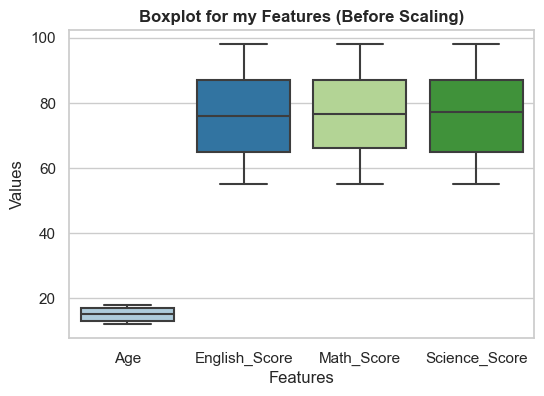

In [405]:
# select the columns i feel need scalling 
selected_columns = ['Age', 'English_Score', 'Math_Score', 'Science_Score']

# for grids
sns.set(style="whitegrid")

# plot the box plots
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_students[selected_columns], palette='Paired')
plt.title('Boxplot for my Features (Before Scaling)', fontweight='bold', fontsize='12')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()


### The substantial difference in the range of Age compared to English Score, Math Score, and Science Score may pose as a potential challenge for my model. Hence we need to scale as it is essential to prevent features with larger ranges from dominating the learning process. This ensures a balanced influence in all features

### I won't scale the Student ID column because it represents unique identifiers for each student, and scaling it would not provide any meaningful interpretation. Similarly, I won't scale the Female, Male, and Unknown columns as they represent categorical variables I encoded through one-hot encoding. Scaling these columns could distort their binary nature, potentially affecting the model's performance

### I will employ the StandardScaler from scikit-learn to scale these features

In [406]:
# only the cols i want to scale
cols_to_scale = ['Age', 'English_Score', 'Math_Score', 'Science_Score']

# define the StandardScaler
std_scaler = StandardScaler()

# fit StandardScaler to my data
df_students_scaled = std_scaler.fit_transform(df_students[cols_to_scale])

# revert it back to a DataFrame
df_students_scaled_2 = pd.DataFrame(df_students_scaled, columns=cols_to_scale)

df_students_scaled_2 = pd.concat([df_students_scaled_2, df_students[['Student_ID', 'Female', 'Male', 'Unknown']]], axis=1)

df_students_scaled_2

,Age,English_Score,Math_Score,Science_Score,Student_ID,Female,Male,Unknown
0,1.546825,-0.961465,-1.676173,-1.272918,1,True,False,False
1,-1.516194,1.026742,-0.459251,1.604172,2,True,False,False
2,1.546825,-0.563823,-0.621507,0.282266,3,True,False,False
3,1.036321,-1.279578,-0.378123,1.604172,4,True,False,False
4,-1.005691,-0.404767,-0.053610,-0.028771,5,False,True,False
...,...,...,...,...,...,...,...,...
995,-0.495188,-0.961465,-1.757301,0.048988,996,True,False,False
996,-0.495188,-0.802408,-1.351660,-1.583955,997,False,False,True
997,0.525818,0.470044,0.352031,-0.184289,998,False,True,False
998,-0.495188,-0.007126,-1.189404,-1.117400,999,False,True,False


### replot box-plot to see changes

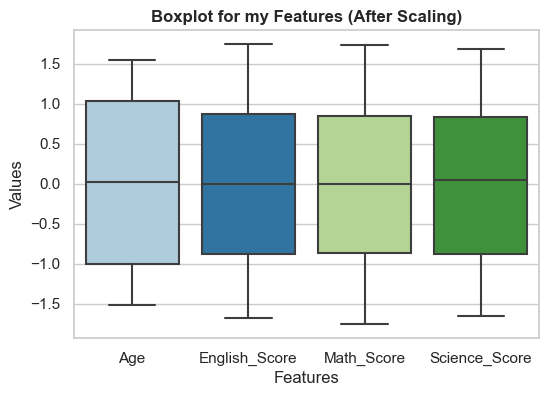

In [407]:
# select the columns i feel need scalling 
selected_columns = ['Age', 'English_Score', 'Math_Score', 'Science_Score']

# for grids
sns.set(style="whitegrid")

# plot the box plots
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_students_scaled_2[selected_columns], palette='Paired')
plt.title('Boxplot for my Features (After Scaling)', fontweight='bold', fontsize='12')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()


### After scaling the features, we observe that they are now centered around 0, and age is more standardized relative to the rest of the features

## Visualizing Gender Proportions

### Next, I will create a pie chart to visualize the proportions of students in each gender category. This visualization is crucial because gender may play a significant role in students' performance due to various factors such as societal expectations, access to resources, and learning styles. Understanding the gender distribution in the class allows us to assess potential gender imbalances and consider their impact on academic outcomes.

### My current DataFrame structure does not facilitate plotting a pie chart by gender directly. Therefore, I will create a new DataFrame to store the sum of respective gender proportions

In [408]:
# create a data frame to store 1d of gender proportion respectivly  
genderPieChart = pd.DataFrame(columns=['Male', 'Female', 'Unknown'])

# conditional statements to calculate each gender repectivly 
genderPieChart.loc[0, 'Male'] = df_students_scaled_2['Male'].sum()
genderPieChart.loc[0, 'Female'] = df_students_scaled_2['Female'].sum()
genderPieChart.loc[0, 'Unknown'] = df_students_scaled_2['Unknown'].sum()

genderPieChart


,Male,Female,Unknown
0,430,465,105


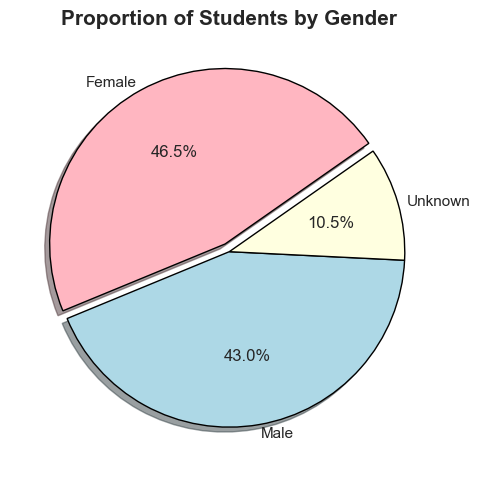

In [409]:
fig, ax = plt.subplots(figsize=(5, 5))

# define my slices, labels, how much my explode is and color
slices = [genderPieChart.loc[0, 'Female'], genderPieChart.loc[0, 'Male'], genderPieChart.loc[0, 'Unknown']]
labels = ['Female', 'Male', 'Unknown']
explode = [0.05, 0, 0]
colors = ['lightpink', 'lightblue', 'lightyellow']

ax.pie(slices, labels=labels, shadow=True, explode=explode,
       startangle=35, autopct='%1.1f%%',
       wedgeprops={'edgecolor': 'black'},
       labeldistance=1.05, colors=colors)

ax.set_title("Proportion of Students by Gender", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()



### From the pie chart, it is evident that the highest proportion of students in the class is female

## Dropping Irrelevant Columns

### The next step in my data preprocessing is to drop the irrelevant column. Upon inspection, I have observed that the Student_ID column serves no additional purpose as the row index already serves as a unique identifier for each student. Therefore, I will proceed to drop the Student_ID column.

In [410]:
df_students_scaled_2.drop(columns='Student_ID', inplace=True)
df_students_scaled_2

,Age,English_Score,Math_Score,Science_Score,Female,Male,Unknown
0,1.546825,-0.961465,-1.676173,-1.272918,True,False,False
1,-1.516194,1.026742,-0.459251,1.604172,True,False,False
2,1.546825,-0.563823,-0.621507,0.282266,True,False,False
3,1.036321,-1.279578,-0.378123,1.604172,True,False,False
4,-1.005691,-0.404767,-0.053610,-0.028771,False,True,False
...,...,...,...,...,...,...,...
995,-0.495188,-0.961465,-1.757301,0.048988,True,False,False
996,-0.495188,-0.802408,-1.351660,-1.583955,False,False,True
997,0.525818,0.470044,0.352031,-0.184289,False,True,False
998,-0.495188,-0.007126,-1.189404,-1.117400,False,True,False


### next i will be converting true/false values into boolean values represented as 1 or 0 for the gender categories

In [411]:
# converting gender columns to boolean 1 and 0 values
df_students_scaled_2['Female'] = df_students_scaled_2['Female'].astype(int)
df_students_scaled_2['Male'] = df_students_scaled_2['Male'].astype(int)
df_students_scaled_2['Unknown'] = df_students_scaled_2['Unknown'].astype(int)

In [412]:
df_students_scaled_2

,Age,English_Score,Math_Score,Science_Score,Female,Male,Unknown
0,1.546825,-0.961465,-1.676173,-1.272918,1,0,0
1,-1.516194,1.026742,-0.459251,1.604172,1,0,0
2,1.546825,-0.563823,-0.621507,0.282266,1,0,0
3,1.036321,-1.279578,-0.378123,1.604172,1,0,0
4,-1.005691,-0.404767,-0.053610,-0.028771,0,1,0
...,...,...,...,...,...,...,...
995,-0.495188,-0.961465,-1.757301,0.048988,1,0,0
996,-0.495188,-0.802408,-1.351660,-1.583955,0,0,1
997,0.525818,0.470044,0.352031,-0.184289,0,1,0
998,-0.495188,-0.007126,-1.189404,-1.117400,0,1,0


## Correlation Visualization

### Next, we will visualize the correlation between different features in the dataset. This step is essential for understanding how each feature is related to others and can help identify any potential multicollinearity issues or patterns in the data

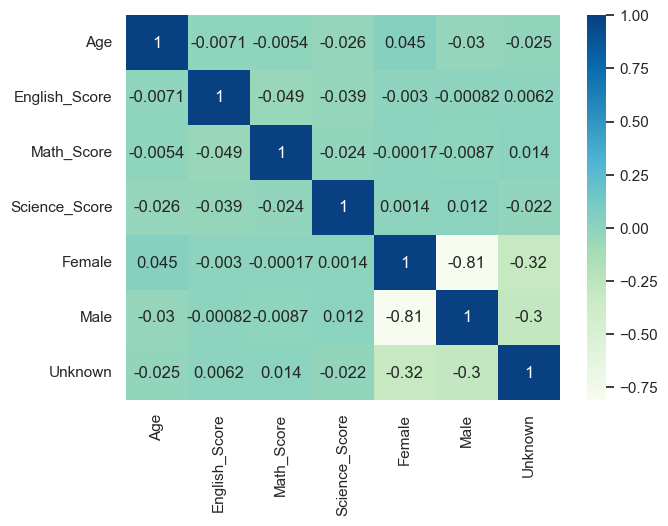

In [413]:
plt.figure(figsize=(7, 5))
sns.heatmap(df_students_scaled_2.corr(), annot=True, cmap="GnBu")
plt.show()

### From the correlation plot, it appears that there are no highly correlated features. This absence of strong correlations suggests that the features are relatively independent of each other, which can be beneficial for clustering model later on as it reduces the risk of redundancy in the data and simplifies interpretation

# Hopkins Cluster Tendency

### Next, I will use the Hopkins statistic to assess the clustering tendency of the dataset. A value close to 0 indicates that the data points are uniformly distributed, making clustering less feasible. Conversely, a value near 1 suggests that the data points are highly clustered, indicating a strong tendency for clustering.


#### The formula of Hopkins statistic is defined as:<br>
$$
H = \frac{\sum_{i=1}^{m}{u_{i}^{d}}}{\sum_{i=1}^{m}{u_{i}^{d}} + \sum_{i=1}^{n}{w_{i}^{d}}}
$$ 
<br>

This formula is used to compute the Hopkins statistic, where \( H \) represents the statistic, \( u_i \) represents the distances to randomly selected points, \( w_i \) represents the distances to the nearest data points, and \( d \) represents the dimensionality of the data.

##### (Taken from Wekipedia)


In [414]:
# setting X from my original df
X = df_students_scaled_2

# converting X into a numpy array
X = X.values

# function to compute the hopkins statistic
def hopkins(X, n):
    d = X.shape[1] # set d as the number of columns in the array
    nbrs = NearestNeighbors(n_neighbors=1).fit(X) # fit knn to X
    
    min_values = np.min(X, axis=0) # calculate the minimum values for each feature for all data points
    max_values = np.max(X, axis=0) # calculate the maximum values for each feature for all data points
    rand_X = np.random.uniform(low=min_values, high=max_values, size=(n, d)) # generate random points within the range of the min max values of each feature
    
    u, _ = nbrs.kneighbors(rand_X, return_distance=True) # find the distance from each random point generated just now to its nearest neighbor in X
    w = np.sum(u) # add the distances up
    
    X_nbrs = nbrs.kneighbors(X, return_distance=False) # find the nearest neighbor for each data point in X
    u_x, _ = nbrs.kneighbors(X, return_distance=True) # find the distance from each data point to its nearest neighbor in X
    w_x = np.sum(u_x) # add the distances up
    
    # calculates the hopkins statistic by dividing the sum of distances to random points w
    # by the sum of distances to nearest data points w_x  plus w.
    return w / (w + w_x) 

# setting the number of data points to sample as the number of rows in the dataset
n_samples = df_students_scaled_2.shape[0]

# calculating the hopkins statistics 
hopkins_statistic = hopkins(X, n_samples)
print("Hopkins statistic:", hopkins_statistic)





Hopkins statistic: 1.0


### Fantastic! We obtained a Hopkins statistic of 1, indicating a strong clustering tendency in the dataset. This suggests that the data points are highly clustered, which is great news for my model

# Dimension Reduction

### Given the multidimensional nature of my dataset and the potential for complex relationships between features, applying t-SNE could help me gain a deeper understanding. t-SNE's lower-dimensional representation simplifies the visualization of complex relationships, patterns, and clusters, aiding in deeper exploration of the data

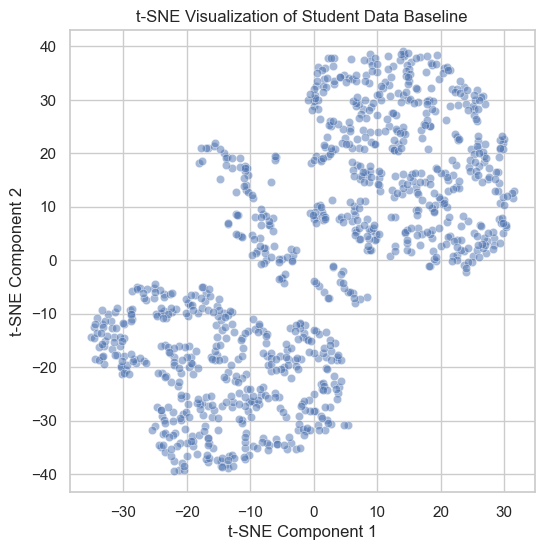

In [415]:
# setting the optimal perplexity based on the square of the amount of rows in my df
optimal_perplexity = round(np.sqrt(df_students_scaled_2.shape[0]))

# carry out t-SNE 
tsne = TSNE(learning_rate=50, perplexity=optimal_perplexity, random_state=42)
tsne_features_before_pca = pd.DataFrame(tsne.fit_transform(df_students_scaled_2))

# plotting t-SNE visualization before PCA
plt.figure(figsize=(6, 6))
sns.scatterplot(x=tsne_features_before_pca.iloc[:, 0], y=tsne_features_before_pca.iloc[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Student Data Baseline')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


### From this visualization, I observe three faint groupings in the data, indicating potential clusters. However, since t-SNE is a dimensionality reduction method used for visualization in this case, these clusters may not directly correspond to definitive clusters in the original high-dimensional space but hey, still a good way to visualize

### To prevent my model from suffering from the curse of dimensionality, I will be using PCA for dimension reduction before applying the clustering algorithm. PCA will help reduce the dimensionality of the feature space while preserving as much variance as possible, making it more computationally efficient and less prone to overfitting. Additionally, PCA can help identify the most informative features for clustering, leading to better-defined clusters and improved model performance

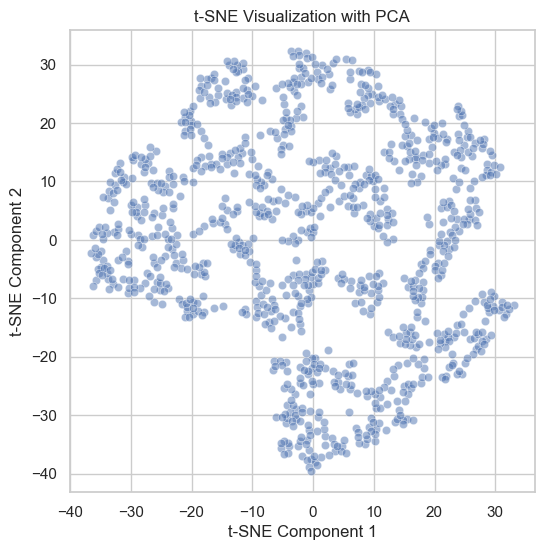

In [436]:
# carry out PCA
pca = PCA(n_components=2)  # i chose 2 as the number of principal components
pca_result = pca.fit_transform(df_students_scaled_2)

# reaply t-SNE to visualize 
tsne = TSNE(n_components=2, random_state=42)
tsne_result_after_pca = tsne.fit_transform(pca_result)

# create df for visualization
tsne_df_after_pca = pd.DataFrame(data=tsne_result_after_pca, columns=['tsne_1', 'tsne_2'])

# plot the t-SNE visualization after PCA
plt.figure(figsize=(6, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df_after_pca, alpha=0.5)
plt.title('t-SNE Visualization with PCA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### After observing that before PCA, three faint clusters were forming, but after PCA, only one large cluster was observed, it suggests that PCA may have merged or obscured the underlying structure of the data. This outcome could be attributed to the loss of information because less informative dimensions were discarded. Considering the outcome where PCA merged distinct clusters into one large cluster, I've decided not to use it for dimension reduction as PCA's loss of information would negatively affect my model

### In that case, I'll explore alternative dimension reduction methods like Gower. Unlike PCA, Gower's approach preserves information from various types of variables. This makes it better suited for heterogeneous datasets like mine, maintaining the richness and diversity of the original data for more accurate clustering

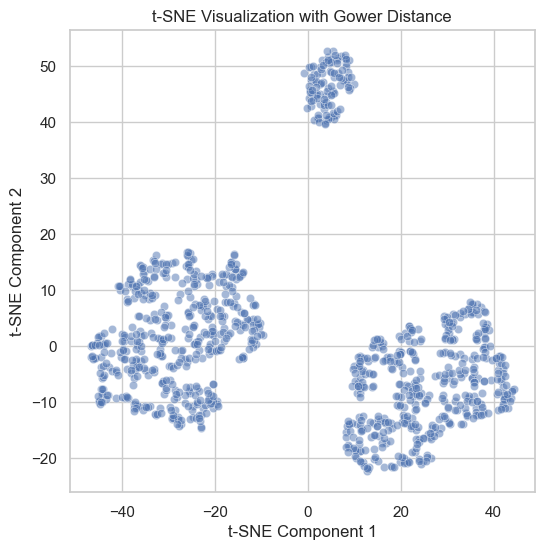

In [417]:
# first calculate gower distance matrix
gower_df = gower.gower_matrix(df_students_scaled_2)
gower_df = pd.DataFrame(gower_df)

# set optimal perplexity for t-SNE
optimal_perplexity = round(np.sqrt(gower_df.shape[0]))

# carry out t-SNE with gower distance
gower_tsne = TSNE(learning_rate=50, perplexity=optimal_perplexity, random_state=42)
gower_tsne_features = pd.DataFrame(gower_tsne.fit_transform(gower_df))

# plotting the t-SNE visualization
plt.figure(figsize=(6, 6))
sns.scatterplot(x=gower_tsne_features.iloc[:, 0], y=gower_tsne_features.iloc[:, 1], alpha=0.5)
plt.title('t-SNE Visualization with Gower Distance')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# make a copy of the t-SNE features for further stuff
scaled_df_copy = gower_tsne_features.copy()

### This is just excellent! What we can see are three distinct clusters emerging from the data. This is particularly advantageous for my clustering algorithm as distinct clusters indicate clear separability among data points. With well-defined clusters, the algorithm can more accurately assign data points to their respective groups, leading to more meaningful and interpretable results. Additionally, having distinct clusters suggests that the algorithm is effectively capturing the underlying structure of the data, enhancing its overall performance and utility for grouping the students into clusters.

## Silouhette Coefficient and Inertia

### Next, I'll use the Silhouette Coefficient and Inertia to evaluate my clustering model. A higher Silhouette score suggests better cluster separation, while lower Inertia indicates more compact clusters. These metrics help assess the quality of the model and guide optimization decisions

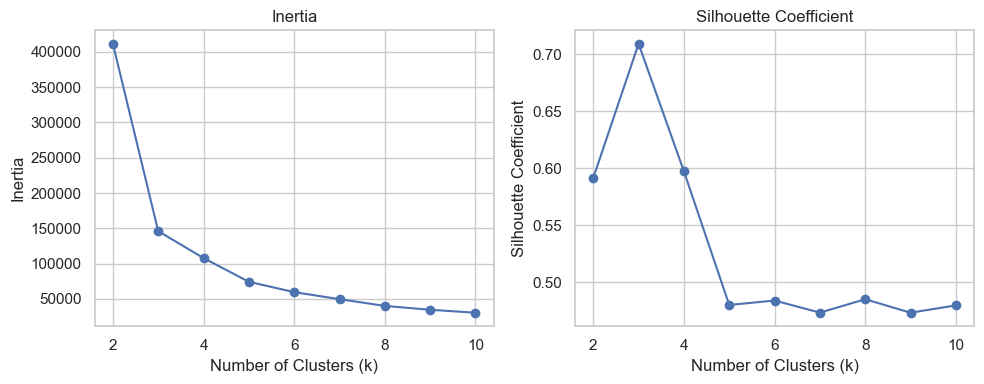

Highest Silhouette Score: 0.7092 (k = 3)


In [438]:
def visualize_kmeans_metrics(data, k_range):
    inertias = []
    silhouette_scores = []

    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, model.labels_))

    plt.figure(figsize=(10, 4))
    
    # plot for inertia
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Inertia')
    
    # plot  for silhouette coefficient
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient')

    plt.tight_layout()
    plt.show()

    # this finds the index of the highest silhouette score
    best_index = np.argmax(silhouette_scores)
    best_k = k_range[best_index]
    best_score = silhouette_scores[best_index]
    
    print(f"Highest Silhouette Score: {best_score:.4f} (k = {best_k})")

k_range = range(2, 11)  # Range of k values to explore
visualize_kmeans_metrics(scaled_df_copy, k_range)


In [419]:
best_k = 3

### From the plots, we observe that the Silhouette Coefficient peaked at 3 clusters, indicating optimal cluster separation. Similarly, the inertia plot exhibited the most significant drop at 3 clusters, suggesting well-defined clusters. Therefore, I will proceed with 3 clusters for my model

# Modelling

### Next, I'll select the top few models based on the evaluation metrics. These models will be chosen based on their performance across the Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index

Rough description of the metrics:

1. **Silhouette Score:**
   - Measures the distance between clusters and the separation between different clusters.
   - Ranges from -1 to 1, with higher values indicating better-defined clusters.

2. **Davies-Bouldin Index:**
   - Measures the average similarity between each cluster and its most similar cluster.
   - A lower value indicates better clustering quality.

3. **Calinski-Harabasz Index (Variance Ratio Criterion):**
   - Measures the ratio of between-cluster variance to within-cluster variance.
   - Higher values indicate better-defined clusters.

These metrics will help assess the quality and effectiveness of the clustering algorithms.


In [420]:
def visualize_clusters(model, data, labels, column1, column2, title):
    cluster_labels = model.fit_predict(data)
    
    # Check the number of unique cluster labels
    unique_labels = len(np.unique(cluster_labels))
    # If there is only one or no cluster the function skips cuz no point
    if unique_labels < 2:
        print(f"Skipping calculation for {title}: Less than 2 clusters.")
        return None
    
    # visualize the clusters
    plt.scatter(data[:, column1], data[:, column2], c=cluster_labels, cmap='Set3')
    plt.title(title)
    plt.xlabel(labels[column1])
    plt.ylabel(labels[column2])
    plt.show()

    # calculate the metrics repectivly 
    silhouette_avg = silhouette_score(data, cluster_labels)
    davies_bouldin = davies_bouldin_score(data, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(data, cluster_labels)

    # print out the scores
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin}')
    print(f'Calinski-Harabasz Score: {calinski_harabasz}')

    return [silhouette_avg, davies_bouldin, calinski_harabasz]

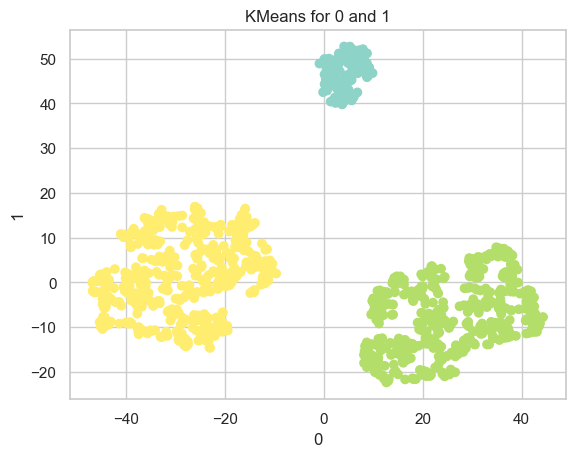

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


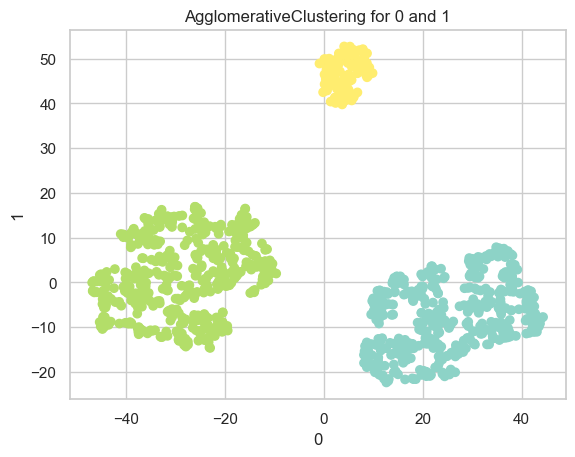

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


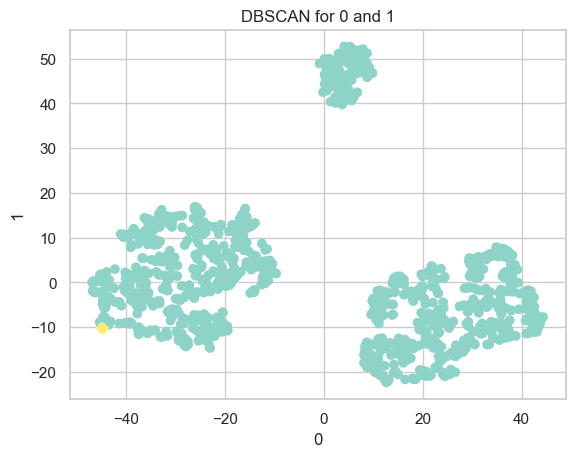

Silhouette Score: 0.05063801631331444
Davies-Bouldin Score: 0.6916708776044026
Calinski-Harabasz Score: 9.633472519580769


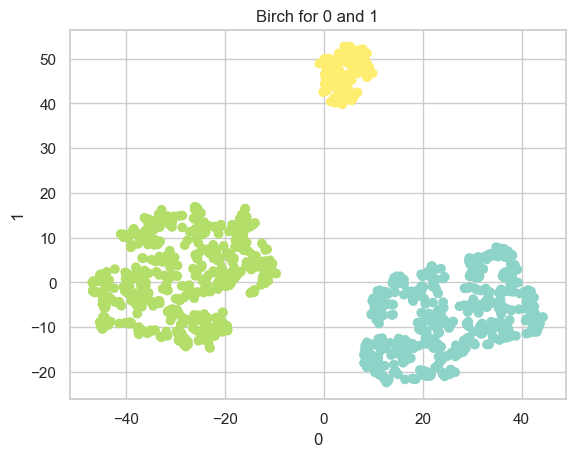

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


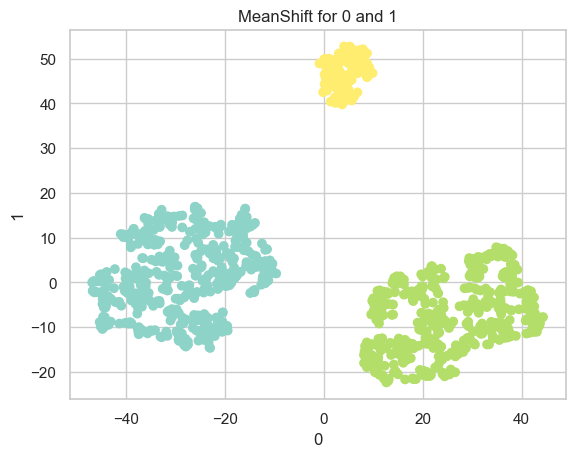

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


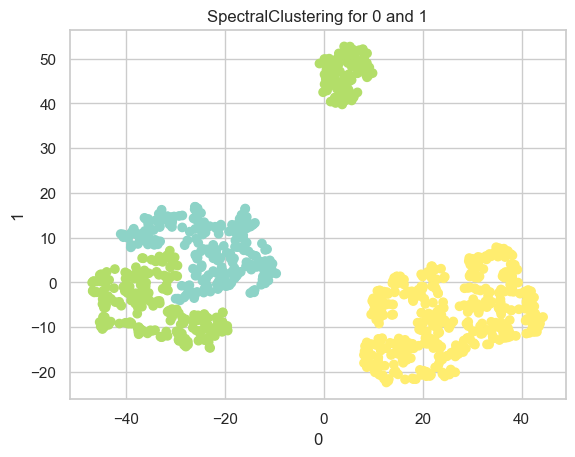

Silhouette Score: 0.37280163168907166
Davies-Bouldin Score: 6.0335505284799416
Calinski-Harabasz Score: 774.0053893863662


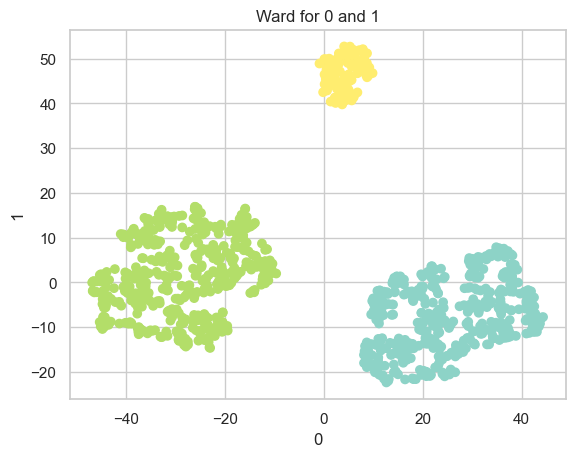

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


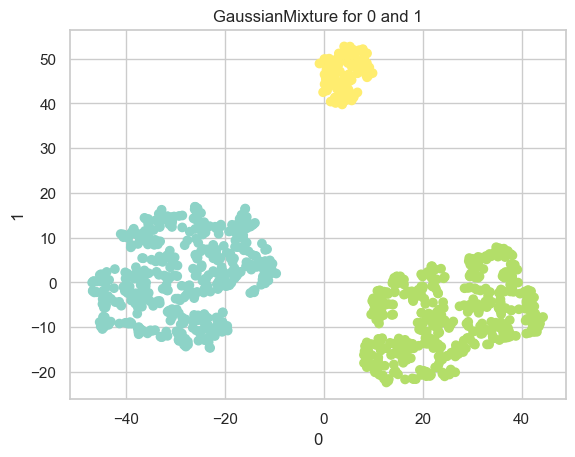

Silhouette Score: 0.7091885805130005
Davies-Bouldin Score: 0.3870846642630414
Calinski-Harabasz Score: 3066.351023397359


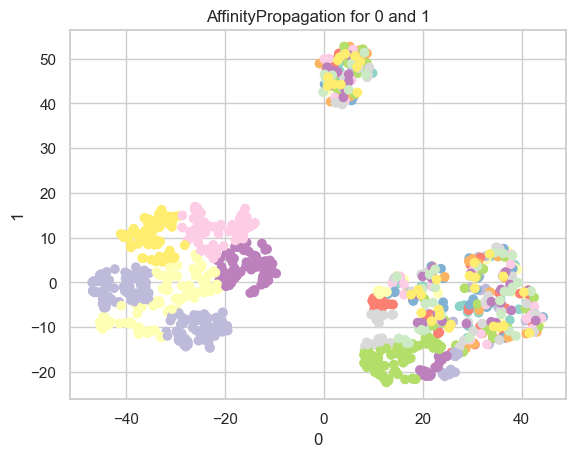

Silhouette Score: 0.22197893261909485
Davies-Bouldin Score: 0.2052345106565618
Calinski-Harabasz Score: 149.41174916382099


In [421]:
from itertools import combinations
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

# instantiate all clustering models
models = {
    'KMeans': KMeans(n_clusters=best_k),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=best_k),
    'DBSCAN': DBSCAN(),
    'Birch': Birch(n_clusters=best_k),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=best_k),
    'Ward': AgglomerativeClustering(n_clusters=best_k, linkage='ward'),
    'GaussianMixture': GaussianMixture(n_components=best_k),
    'AffinityPropagation': AffinityPropagation()
}

# put in my df
data = scaled_df_copy.values
feature_labels = scaled_df_copy.columns 

# visualize clusters and calculate scores
model_names = []
combinations_list = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

numbers = [0, 1]

# goes through all clustering models and visualizes the clusters also calculating evaluation metrics for each model
for model_name, model in models.items():
    for comb in combinations(numbers, 2):
        num1, num2 = comb
        values = visualize_clusters(model, data, feature_labels, num1, num2, f"{model_name} for {feature_labels[num1]} and {feature_labels[num2]}")
        if values is not None:
            model_names.append(model_name)
            combinations_list.append(", ".join((str(feature_labels[num1]), str(feature_labels[num2]))))
            silhouette_scores.append(values[0])
            davies_bouldin_scores.append(values[1])
            calinski_harabasz_scores.append(values[2])


In [422]:
# creates df with clustering results
clustering_results = pd.DataFrame({
    'Model': model_names,
    'Combination': combinations_list,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Score': davies_bouldin_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores
})

clustering_results


,Model,Combination,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,KMeans,"0, 1",0.709189,0.387085,3066.351023
1,AgglomerativeClustering,"0, 1",0.709189,0.387085,3066.351023
2,DBSCAN,"0, 1",0.050638,0.691671,9.633473
3,Birch,"0, 1",0.709189,0.387085,3066.351023
4,MeanShift,"0, 1",0.709189,0.387085,3066.351023
5,SpectralClustering,"0, 1",0.372802,6.033551,774.005389
6,Ward,"0, 1",0.709189,0.387085,3066.351023
7,GaussianMixture,"0, 1",0.709189,0.387085,3066.351023
8,AffinityPropagation,"0, 1",0.221979,0.205235,149.411749


### GaussianMixture, Ward, MeanShift, Birch, AgglomerativeClustering, and KMeans demonstrated the highest scores across all evaluation metrics. To make a more informed selection among these models, I can conduct further analysis such as comparing their computational efficiency

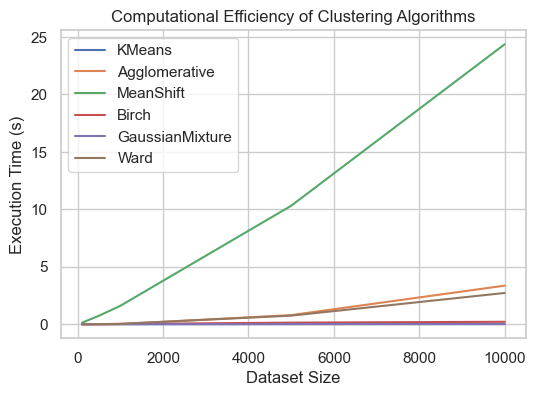

In [423]:
# create a testing dataset with different sizes 
dataset_sizes = [100, 500, 1000, 5000, 10000]  

# initialize dicts to store execution times for each algorithm
execution_times = {
    'KMeans': [],
    'Agglomerative': [],
    'MeanShift': [],
    'Birch': [],
    'GaussianMixture': [],
    'Ward': []
}

# foop over dataset sizes
for size in dataset_sizes:
    # Generate synthetic dataset
    X, _ = make_blobs(n_samples=size, centers=3, n_features=2, random_state=42)
    
    # measure execution time for each algorithm
    for algorithm in execution_times.keys():
        start_time = time.time()
        
        # fit the clustering algorithm
        if algorithm == 'KMeans':
            model = KMeans(n_clusters=3, random_state=42)
            model.fit(X)
        elif algorithm == 'Agglomerative':
            model = AgglomerativeClustering(n_clusters=3)
            model.fit(X)
        elif algorithm == 'DBSCAN':
            model = DBSCAN(eps=0.5, min_samples=5)
            model.fit(X)
        elif algorithm == 'MeanShift':
            model = MeanShift()
            model.fit(X)
        elif algorithm == 'Birch':
            model = Birch(n_clusters=3)
            model.fit(X)
        elif algorithm == 'GaussianMixture':
            model = GaussianMixture(n_components=3)
            model.fit(X)
        elif algorithm == 'Ward':
            Z = linkage(X, method='ward')
            dendrogram(Z, no_plot=True)
        
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times[algorithm].append(execution_time)

# plot the results
plt.figure(figsize=(6, 4))
for algo, times in execution_times.items():
    plt.plot(dataset_sizes, times, label=algo)
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (s)')
plt.title('Computational Efficiency of Clustering Algorithms')
plt.legend()
plt.show()

### Since the plot indicates that as the dataset size increases, Meanshift, Ward and Agglomerative algorithms take longer to execute compared to the rest of the algorithms, we can conclude that they are not computationally efficient. Therefore, I won't select them to be used as my clustering algorithms

# Hyper Tuning

### Next, we proceed to hyperparameter tuning our model to enhance its performance further

### I will use GridSearchCV to find the best parameters for optimizing my model

In [424]:
# Dictionary to store hyperparameter tuning results
scoring_results = {}

# Custom scoring function using silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

### Hyper Parameter Tunung for KMeans

In [425]:
# hyperparameter tunings
param_grid = {
    'n_clusters': [best_k],
    'init': ['k-means++', 'random'], 
    'max_iter': [100, 200, 300],  
    'n_init': [10, 20, 30], 
    'tol': [1e-3, 1e-4, 1e-5],  
    'algorithm': ['auto', 'full', 'elkan'],  
    'verbose': [0, 1, 2]  
}

# instantaite kmeans and gridsearchcv
model = KMeans(random_state=42)
km_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

# fit gridsearchcv to the data
km_grid_search.fit(scaled_df_copy)

# store the best parameters and best score in the scoring_results dictionary
scoring_results['KMeans'] = {
    "best_params": km_grid_search.best_params_,
    "best_score": km_grid_search.best_score_
}

# print the best parameters and best score
print("Best Parameters:", km_grid_search.best_params_)
print("Best Score:", km_grid_search.best_score_)

Best Parameters: {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3, 'n_init': 10, 'tol': 0.001, 'verbose': 0}
Best Score: 0.7087346196174622


#### Hyper Parameter Tuning for Birch

In [426]:
# hyperparameter tunings
param_grid = {
    'n_clusters': [best_k],
    'threshold': [0.1, 0.2, 0.3, 0.4, 0.5],  
    'branching_factor': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400],
    'compute_labels': [True, False],  
    'copy': [True, False],  
}

# instantaite birch and gridsearchcv
model = Birch()
birch_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

# fit gridsearchcv to the data
birch_grid_search.fit(scaled_df_copy)

# store the best parameters and best score in the scoring_results dictionary
scoring_results['Birch'] = {
    "best_params": birch_grid_search.best_params_,
    "best_score": birch_grid_search.best_score_
}

# print the best parameters and best score
print("Best Parameters:", birch_grid_search.best_params_)
print("Best Score:", birch_grid_search.best_score_)


Best Parameters: {'branching_factor': 10, 'compute_labels': True, 'copy': True, 'n_clusters': 3, 'threshold': 0.1}
Best Score: 0.7087346196174622


### Hyper Parameter Tuning for Gaussian Mixture

In [427]:
# hyperparameter tunings
param_grid = {
    'n_components': [best_k],  
    'covariance_type': ['full', 'tied', 'diag', 'spherical'], 
    'init_params': ['kmeans', 'random'], 
    'max_iter': [100, 200, 300], 
    'tol': [1e-3, 1e-4, 1e-5]
}

# instantaite gaussian mixture and gridsearchcv
model = GaussianMixture()
gmm_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

# fit gridsearchcv to the data
gmm_grid_search.fit(scaled_df_copy)

# store the best parameters and best score in the scoring_results dictionary
scoring_results['GaussianMixture'] = {
    "best_params": gmm_grid_search.best_params_,
    "best_score": gmm_grid_search.best_score_
}

# print the best parameters and best score
print("Best Parameters:", gmm_grid_search.best_params_)
print("Best Score:", gmm_grid_search.best_score_)


Best Parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'n_components': 3, 'tol': 0.001}
Best Score: 0.7087346196174622


In [428]:
scoring_results_df = pd.DataFrame(scoring_results).transpose()
display(scoring_results_df)

,best_params,best_score
KMeans,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",0.708735
Birch,"{'branching_factor': 10, 'compute_labels': Tru...",0.708735
GaussianMixture,"{'covariance_type': 'full', 'init_params': 'km...",0.708735


# Interpretation

### Now, we interpret the clusters from our models. Although the best value of k is 3 according to the inertia and silhouette plots, I've set the number of clusters to 7. This decision balances accuracy with interpretability, as I found that n_clusters = 7 offers the best interpretability for our analysis.

In [491]:
# Define the best parameters for KMeans
best_params = {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 7, 'n_init': 10, 'tol': 0.001, 'verbose': 0}

# Instantiate KMeans with the best parameters
kmeans_model = KMeans(**best_params)

# Fit the KMeans model to the scaled data
kmeans_model.fit(scaled_df_copy)

# Save the trained KMeans model to a file
pickle.dump(kmeans_model, open("./Saved_models/KMeans_Clustering_Model.pkl", "wb"))

# Load the saved KMeans model from the file
loaded_kmeans_model = pickle.load(open("./Saved_models/KMeans_Clustering_Model.pkl", "rb"))

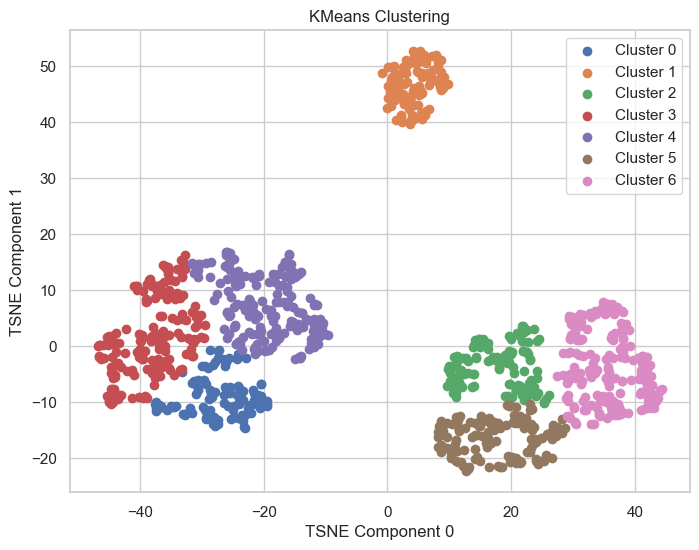

In [492]:
# Get the cluster labels assigned by the model
cluster_labels = kmeans_model.labels_

# Get unique cluster labels
unique_labels = np.unique(cluster_labels)

# Visualize the clusters using scatter plots and a legend
plt.figure(figsize=(8, 6))

for label in unique_labels:
    cluster_points = scaled_df_copy[cluster_labels == label]
    plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {label}')

plt.title('KMeans Clustering')
plt.xlabel('TSNE Component 0')
plt.ylabel('TSNE Component 1')
plt.legend()
plt.show()


In [480]:
# df_students.drop(columns='Student_ID', inplace=True)
df_students

,Age,English_Score,Math_Score,Science_Score,Unknown,Female,Male
0,18,64.0,56.0,60,False,True,False
1,12,89.0,71.0,97,False,True,False
2,18,69.0,69.0,80,False,True,False
3,17,60.0,72.0,97,False,True,False
4,13,71.0,76.0,76,False,False,True
...,...,...,...,...,...,...,...
995,14,64.0,55.0,77,False,True,False
996,14,66.0,60.0,56,True,False,False
997,16,82.0,81.0,74,False,False,True
998,14,76.0,62.0,62,False,False,True


In [493]:
df_final = df_students.copy()

df_final["cluster"] = cluster_labels

df_final

,Age,English_Score,Math_Score,Science_Score,Unknown,Female,Male,cluster
0,18,64.0,56.0,60,False,True,False,4
1,12,89.0,71.0,97,False,True,False,0
2,18,69.0,69.0,80,False,True,False,4
3,17,60.0,72.0,97,False,True,False,4
4,13,71.0,76.0,76,False,False,True,6
...,...,...,...,...,...,...,...,...
995,14,64.0,55.0,77,False,True,False,0
996,14,66.0,60.0,56,True,False,False,1
997,16,82.0,81.0,74,False,False,True,5
998,14,76.0,62.0,62,False,False,True,2


### I will be using a decision tree to interpret the clusters. Decision trees provide a straightforward and interpretable representation of how clusters are formed by recursively partitioning the data based on feature values. By analyzing the tree, we can identify the most important features and their thresholds for splitting the data into different clusters

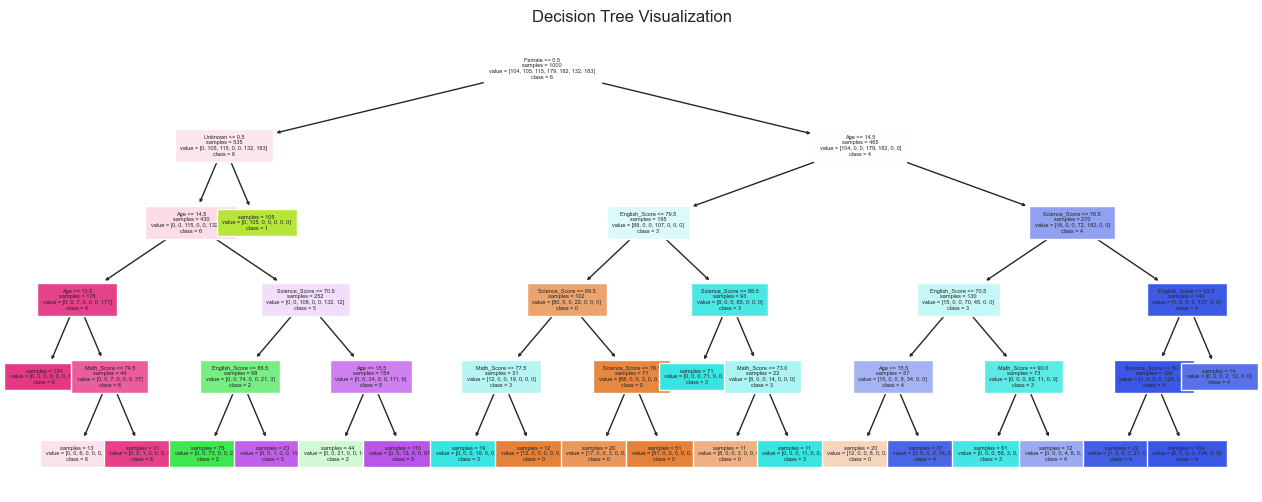

In [494]:
# Define the DecisionTreeClassifier with optimized parameters
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

# Fit the classifier to the data
clf.fit(df_final.drop(columns="cluster"), df_final["cluster"])

# Plot the decision tree with rounded values displayed in each node
plt.figure(figsize=(16, 6))
plot_tree(
    clf,
    feature_names=df_final.drop(columns="cluster").columns,
    class_names=np.unique(df_final["cluster"].values.astype(str)),
    impurity=False,
    filled=True,
    fontsize=4,
)
plt.title("Decision Tree Visualization")
plt.show()


### 

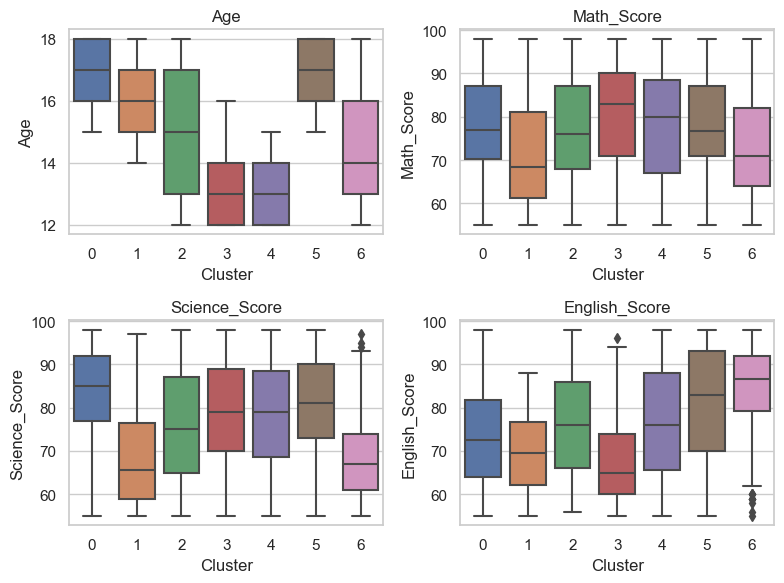

In [483]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Boxplot for Age distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Age", ax=ax[0, 0])
ax[0, 0].set_xlabel('Cluster')
ax[0, 0].set_ylabel('Age')
ax[0, 0].set_title('Age') 

# Boxplot for Math_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Math_Score", ax=ax[0, 1])
ax[0, 1].set_xlabel('Cluster')
ax[0, 1].set_ylabel('Math_Score')
ax[0, 1].set_title('Math_Score')

# Boxplot for Science_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Science_Score", ax=ax[1, 0])
ax[1, 0].set_xlabel('Cluster')
ax[1, 0].set_ylabel('Science_Score')
ax[1, 0].set_title('Science_Score') 

# Boxplot for English_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="English_Score", ax=ax[1, 1])
ax[1, 1].set_xlabel('Cluster')
ax[1, 1].set_ylabel('English_Score')
ax[1, 1].set_title('English_Score') 

plt.tight_layout()
plt.show()



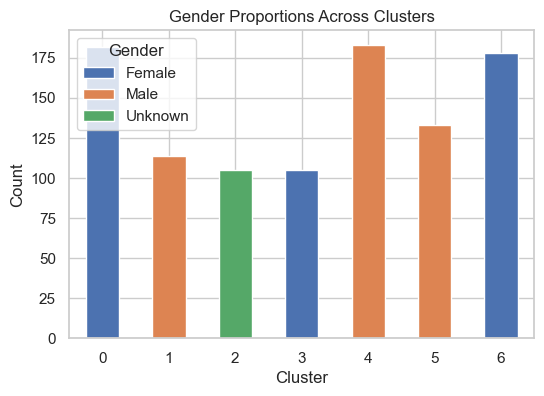

In [484]:
# Combine Male, Female, and Unknown columns into a single Gender column
df_final['Gender'] = df_final[['Male', 'Female', 'Unknown']].idxmax(axis=1)

# Count the number of occurrences of each gender in each cluster
gender_counts = df_final.groupby(['cluster', 'Gender']).size().reset_index(name='Count')

# Pivot the table to have clusters as rows and genders as columns
gender_counts_pivot = gender_counts.pivot(index='cluster', columns='Gender', values='Count').fillna(0)

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts_pivot.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender Proportions Across Clusters')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.show()





In [485]:
# Define the best parameters for Birch
best_params = {'branching_factor': 10, 'compute_labels': True, 'copy': True, 'n_clusters': 7, 'threshold': 0.1}

# Instantiate Birch with the best parameters
birch_model = Birch(**best_params)

# Fit the Birch model to the scaled data
birch_model.fit(scaled_df_copy)

# Save the trained Birch model to a file
pickle.dump(birch_model, open("./Saved_models/Birch_Clustering_Model.pkl", "wb"))

# Load the saved Birch model from the file
loaded_birch_model = pickle.load(open("./Saved_models/Birch_Clustering_Model.pkl", "rb"))


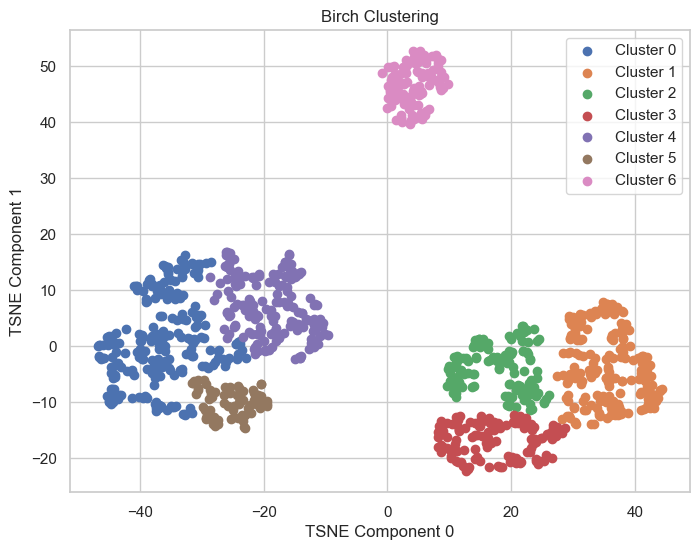

In [486]:
# Get the cluster labels assigned by the model
cluster_labels = birch_model.labels_

# Get unique cluster labels
unique_labels = np.unique(cluster_labels)

# Visualize the clusters using scatter plots and a legend
plt.figure(figsize=(8, 6))

for label in unique_labels:
    cluster_points = scaled_df_copy[cluster_labels == label]
    plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {label}')

plt.title('Birch Clustering')
plt.xlabel('TSNE Component 0')
plt.ylabel('TSNE Component 1')
plt.legend()
plt.show()


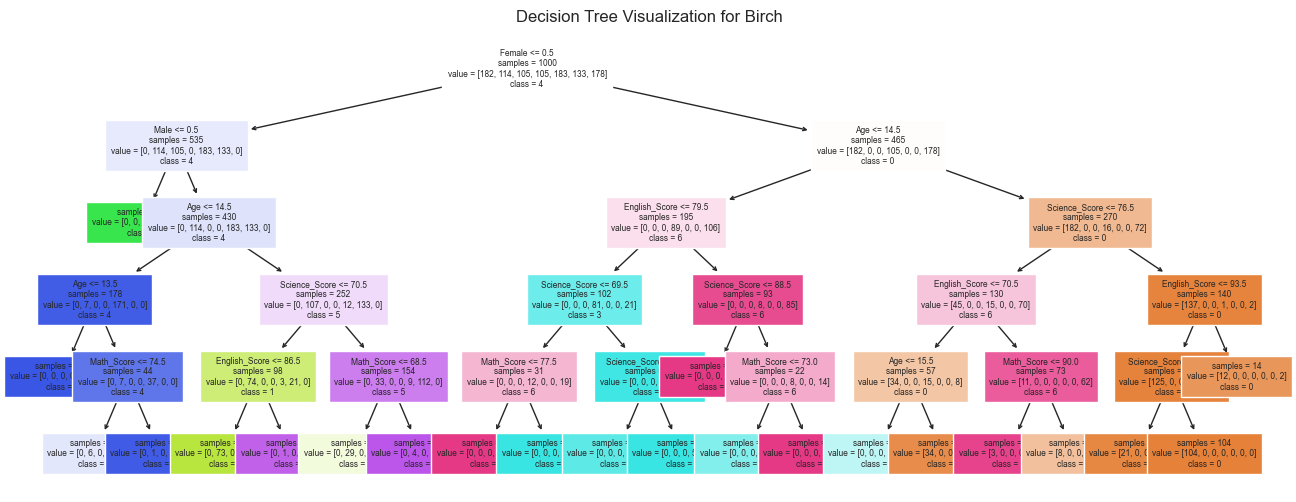

In [487]:
# Perform one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df_final.drop(columns="cluster"))

# Define the DecisionTreeClassifier with optimized parameters
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

# Fit the classifier to the data
clf.fit(df_encoded, df_final["cluster"])

# Plot the decision tree with rounded values displayed in each node
plt.figure(figsize=(16, 6))
plot_tree(
    clf,
    feature_names=df_encoded.columns,  # Use the encoded feature names
    class_names=np.unique(df_final["cluster"].values.astype(str)),
    impurity=False,
    filled=True,
    fontsize=6,
)
plt.title("Decision Tree Visualization for Birch")
plt.show()


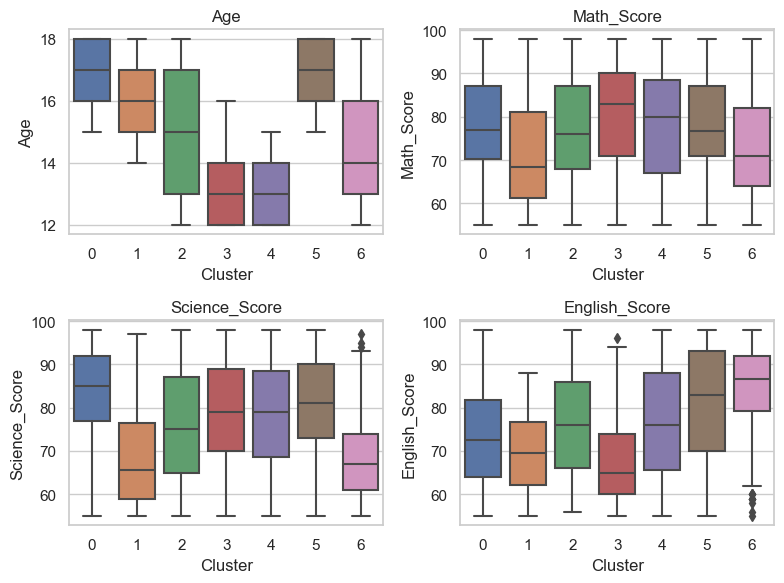

In [488]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Boxplot for Age distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Age", ax=ax[0, 0])
ax[0, 0].set_xlabel('Cluster')
ax[0, 0].set_ylabel('Age')
ax[0, 0].set_title('Age') 

# Boxplot for Math_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Math_Score", ax=ax[0, 1])
ax[0, 1].set_xlabel('Cluster')
ax[0, 1].set_ylabel('Math_Score')
ax[0, 1].set_title('Math_Score')

# Boxplot for Science_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="Science_Score", ax=ax[1, 0])
ax[1, 0].set_xlabel('Cluster')
ax[1, 0].set_ylabel('Science_Score')
ax[1, 0].set_title('Science_Score') 

# Boxplot for English_Score distribution across clusters
sns.boxplot(data=df_final, x="cluster", y="English_Score", ax=ax[1, 1])
ax[1, 1].set_xlabel('Cluster')
ax[1, 1].set_ylabel('English_Score')
ax[1, 1].set_title('English_Score') 

plt.tight_layout()
plt.show()


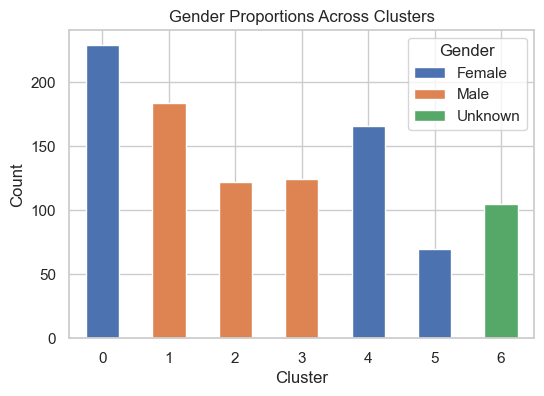

In [489]:
# Get the cluster labels assigned by the Birch model
cluster_labels = birch_model.labels_

# Add the cluster labels to your DataFrame
df_final['Cluster'] = cluster_labels

# Combine Male, Female, and Unknown columns into a single Gender column
df_final['Gender'] = df_final[['Male', 'Female', 'Unknown']].idxmax(axis=1)

# Count the number of occurrences of each gender in each cluster
gender_counts = df_final.groupby(['Cluster', 'Gender']).size().reset_index(name='Count')

# Pivot the table to have clusters as rows and genders as columns
gender_counts_pivot = gender_counts.pivot(index='Cluster', columns='Gender', values='Count').fillna(0)

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts_pivot.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender Proportions Across Clusters')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.show()


## Conclusion

**For KMeans Clustering**

**Cluster 0**
- Age Range: 16-18
- Gender: Female
- Mean Math Scores: 77
- Mean Science Scores: 85
- Mean English Scores: 73

**Cluster 1**
- Age Range: 15-17
- Gender: Male
- Mean Math Scores: 79
- Mean Science Scores: 65
- Mean English Scores: 69

**Cluster 2**
- Age Range: 13-17
- Gender: Unknown (Gender Ambiguous)
- Mean Math Scores: 76
- Mean Science Scores: 75
- Mean English Scores: 76

**Cluster 3**
- Age Range: 12-14
- Gender: Female
- Mean Math Scores: 83
- Mean Science Scores: 79
- Mean English Scores: 65

**Cluster 4**
- Age Range: 12-14
- Gender: Male
- Mean Math Scores: 80
- Mean Science Scores: 78
- Mean English Scores: 75

**Cluster 5**
- Age Range: 16-18
- Gender: Male
- Mean Math Scores: 77
- Mean Science Scores: 82
- Mean English Scores: 83

**Cluster 6**
- Age Range: 13-16
- Gender: Female
- Mean Math Scores: 71
- Mean Science Scores: 66
- Mean English Scores: 86

**For Birch Clustering**

**Cluster 0**
- Age Range: 16-18
- Gender: Female
- Mean Math Scores: 77
- Mean Science Scores: 85
- Mean English Scores: 72

**Cluster 1**
- Age Range: 15-17
- Gender: Male
- Mean Math Scores: 68
- Mean Science Scores: 65
- Mean English Scores: 69

**Cluster 2**
- Age Range: 13-17
- Gender: Male
- Mean Math Scores: 76
- Mean Science Scores: 75
- Mean English Scores: 76

**Cluster 3**
- Age Range: 12-14
- Gender: Male
- Mean Math Scores: 83
- Mean Science Scores: 79
- Mean English Scores: 64

**Cluster 4**
- Age Range: 12-14
- Gender: Female
- Mean Math Scores: 80
- Mean Science Scores: 79
- Mean English Scores: 76

**Cluster 5**
- Age Range: 16-18
- Gender: Female
- Mean Math Scores: 76
- Mean Science Scores: 81
- Mean English Scores: 83

**Cluster 6**
- Age Range: 13-16
- Gender: Unknown (Gender Ambiguous)
- Mean Math Scores: 71
- Mean Science Scores: 66
- Mean English Scores: 86


### For the KMeans clustering, the group of students that may require the most assistance would be cluster 1. Similarly, for Birch clustering, it would be cluster 1. This assessment is based on the observation that the mean scores for cluster 1 are comparatively lower than those of the other clusters. Hence, identifying these clusters allows for targeted interventions and support strategies to address the specific needs of these students